## Libraries

### Install packages and download models

In [58]:
# Remove capture line to see output if something goes wrong
%%capture
!pip install bertopic
!pip install kaleido
!python -m spacy download en_core_web_md

### Imports

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import pickle

# Preprocessing and Gensim
import spacy
from spacy.lang.en import stop_words
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from gensim import corpora, models
import logging

# BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from hdbscan import HDBSCAN
from bertopic import BERTopic

# spaCy NLP
nlp = spacy.load("en_core_web_md")

## Preprocess text

### Filter out non-English documents

In [ ]:
# https://huggingface.co/papluca/xlm-roberta-base-language-detection
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

df_blogs = pd.read_csv("blogs.csv").dropna(subset="blog")
for i, row in tqdm(df_blogs.iterrows()):
    blog = row["blog"]

    blog = blog.strip()
    lang = pipe(blog, truncation=True)

    df_blogs.loc[i, "blog"] = blog
    df_blogs.loc[i, "lang"] = lang[0]["label"]

df_blogs = df_blogs[df_blogs["lang"] == "en"]
df_blogs.to_csv("blogs.csv")

Device set to use cpu
3138it [58:25,  1.12s/it]


### Named entity recognition

In [9]:
df_blogs = pd.read_csv("blogs.csv", index_col=0)

# Named entity recognition model
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner = pipeline("ner", model=model, tokenizer=tokenizer)

for index, row in tqdm(df_blogs.iterrows()):
  ner_res = ner(row["blog"]) # Run NER model on blog
  ner_res = [res for res in ner_res if "ORG" not in res["entity"] and "MISC" not in res["entity"]] # Don't care about the org or misc tag

  # Apply some post-processing to concatenate tokens
  ner_res_post_proc = []
  for i, res in enumerate(ner_res):
    if res["word"].startswith("##"):
      # Don't append if it's part of a word
      continue
    elif i != len(ner_res) - 1:
      # If it's not the last element in the list
      j = 1
      full_res = res
      full_res["entity"] = res["entity"].replace("B-LOC", "LOC").replace("I-LOC", "LOC").replace("B-PER", "PER").replace("I-PER", "PER")
      while ner_res[i + j]["word"].startswith("##"):
        next_res = ner_res[i + j]
        full_res["word"] += next_res["word"].replace("##", "")
        full_res["end"] = next_res["end"]


        # If end is reached, stop. Else continue
        if i + j == len(ner_res) - 1:
          break
        else:
          j += 1

      ner_res_post_proc.append(full_res)

  # Replace tokens by their entity
  ner_blog = row["blog"]
  len_change = 0
  for res in ner_res_post_proc:
    ner_blog = ner_blog[:res["start"] - len_change] + res["entity"] + ner_blog[res["end"] - len_change:]
    len_change += len(res["word"]) - 3


  # Clean up some weird issues
  def clean_up_ner_blogs(blog):
    blog = re.sub(r'\b\w*LOC\w*\b', 'LOC', blog)
    blog = re.sub(r'\b\w*PER\w*\b', 'PER', blog)

    return blog


  df_blogs["ner_blog"] = df_blogs["ner_blog"].apply(clean_up_ner_blogs)
  df_blogs.loc[index, "ner_blog"] = ner_blog

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
2967it [1:05:43,  1.33s/it]


In [27]:
df_blogs.to_csv("blogs.csv")

### Stop words

In [51]:
# Define stop words
stop_words_to_use = list(stop_words.STOP_WORDS)
stop_words_to_use += ["ride", "rides", "riding", "cycling", "cycle", "bicycle", "bicycling", "tour", "touring", "day", "bike", "bikes", "biking", "road", "get", "go", "mile", "miles", "km", "kms", "metre", "like", "way", "good", "come", "look", "nice", "think", "trip", "know", "see", "great", "today", "distance", "rained", "raining", "weather", "rain", "winds", "wind", "storm", "tornado", "tailwind", "evening", "warm", "sun"]

### Apply standard preprocessing

In [29]:
# https://spacy.io/usage/linguistic-features
def preprocess_text(file_path, nlp, ner_blogs=False, stop_word_removal=True, non_alpha_removal=True, lemmatization=True, lowercasing=True, stop_words_to_use=[]):
    df_blogs = pd.read_csv(file_path)
    documents = []

    for i, row in tqdm(df_blogs.iterrows()):
        if ner_blogs:
          doc = nlp(row["ner_blog"]) # Convert to spaCy doc
        else:
          doc = nlp(row["blog"]) # Convert to spaCy doc

        if len(doc) > 1:
            if non_alpha_removal: # Remove non alpha characters
                doc = [token for token in doc if token.is_alpha]

            if lemmatization: # Lemmatize words
                doc = [token.lemma_ for token in doc]

            if stop_word_removal: # Remove stop words
                doc = [token for token in doc if token not in stop_words_to_use]

            if lowercasing: # Lowercase words
                doc = [token.lower() for token in doc]

            documents.append(doc)

    # https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html
    dictionary = corpora.Dictionary(documents)
    dictionary.filter_extremes(no_below=2) # Filter out tokens appearing only once
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    if ner_blogs:
      dictionary.save("ner_dictionary.dict")
      corpora.MmCorpus.serialize("ner_corpus.mm", corpus)
    else:
      dictionary.save("dictionary.dict")
      corpora.MmCorpus.serialize("corpus.mm", corpus)


# Generate dictionary and corpus for both cases
preprocess_text("blogs.csv", nlp, ner_blogs=True, stop_words_to_use=stop_words_to_use)
preprocess_text("blogs.csv", nlp, ner_blogs=False, stop_words_to_use=stop_words_to_use)

2967it [04:24, 11.21it/s]
2967it [04:20, 11.40it/s]


## Modelling

In [31]:
# Allow logging
logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)


def clear_logfile():
    # To empty the log file
    with open("gensim.log", "w"):
        pass


def parse_logfile():
    """Parse gensim.log to extract the log-likelihood scores.

    Returns:
        A list of log-likelihood scores.
    """
    matcher = re.compile(r'(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

### LDA

NER:  True 
TF-IDF (else BOW):  True
Topic 0: iffy, sparta, tendon, amish, eureka, dynamic, climber, cache, fortress, hangover
Topic 1: jinx, reporter, vote, tidy, sorry, intermittent, terribly, distance, osprey, total
Topic 2: saw, aunt, aim, hurry, outskirt, rig, recumbent, culture, present, maori
Topic 3: lanark, trails, prince, mascot, anonymous, ute, peggy, hide, baffle, link
Topic 4: head, find, start, climb, wind, rain, time, stop, hill, town
Topic 5: pontoon, sundowner, neon, lisa, incorporate, pipeline, hind, blah, molly, â
Topic 6: outlet, brunch, luxurious, utah, resturant, pebble, mesquite, corps, café, kauri
Topic 7: icelandic, sw, bugger, rant, lull, elevation, gain, gin, excerpt, height
Topic 8: salt, entertaining, engine, trash, coastline, paceline, leukemia, lad, municipal, ernie
Topic 9: ortlieb, grazing, carousel, pricey, dingo, tandems, era, page, part, kg



NER:  True 
TF-IDF (else BOW):  False
Topic 0: turn, long, right, find, town, pass, start, hill, stop, time


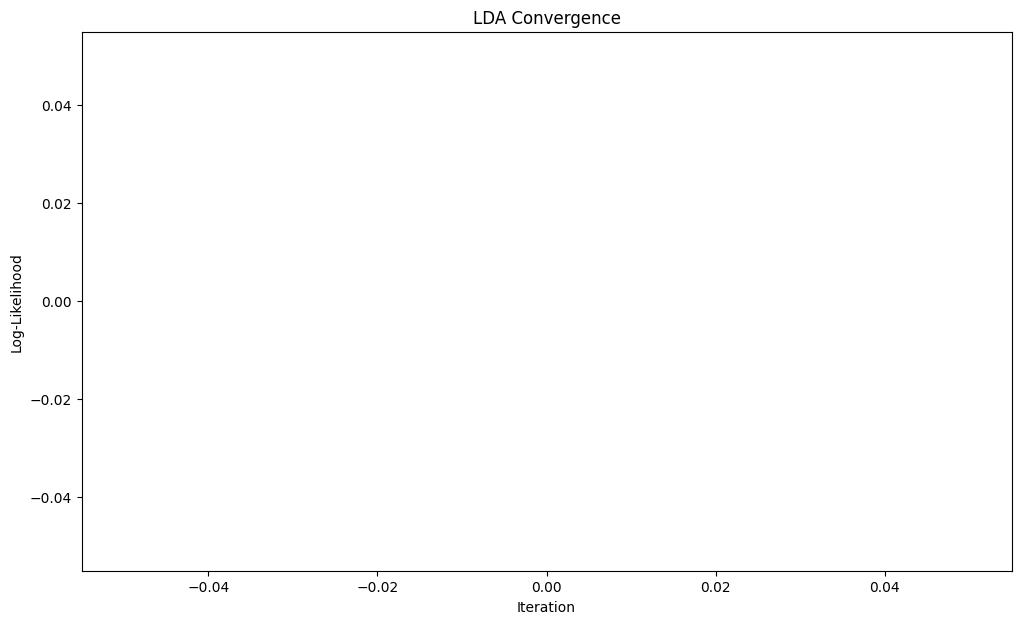

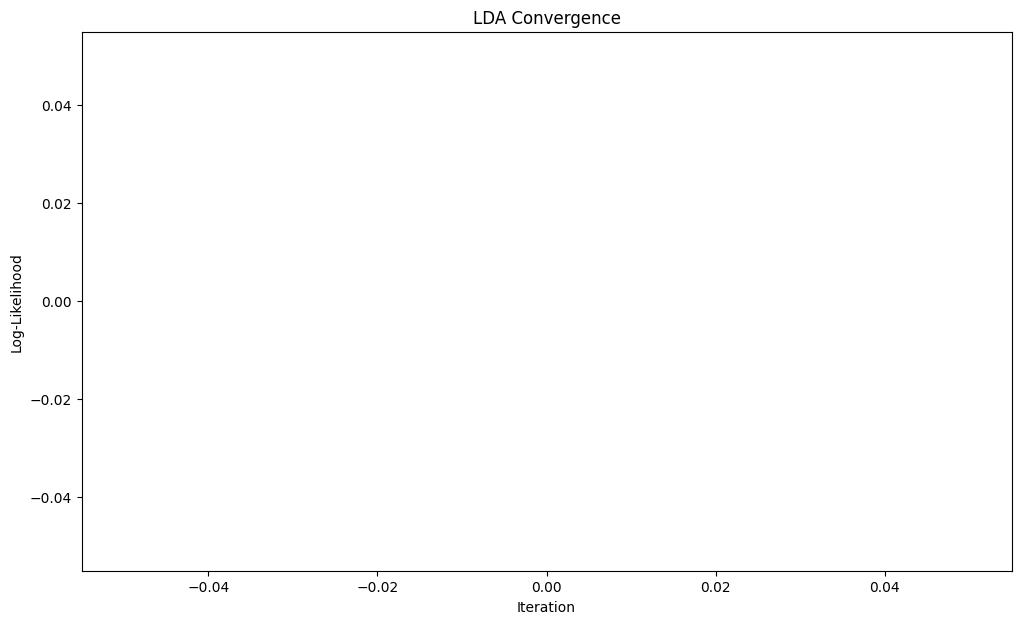

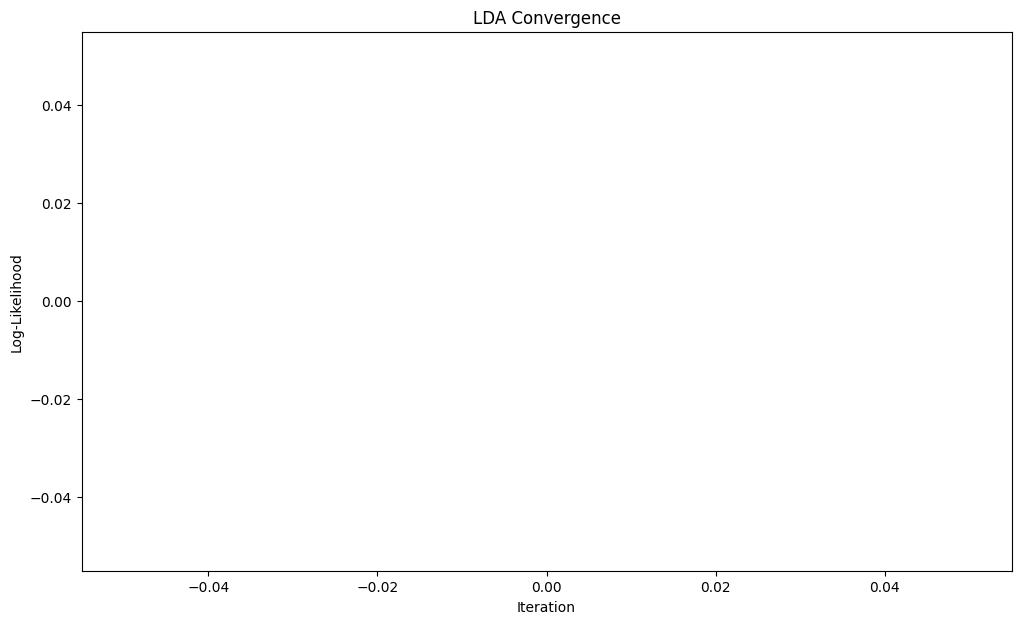

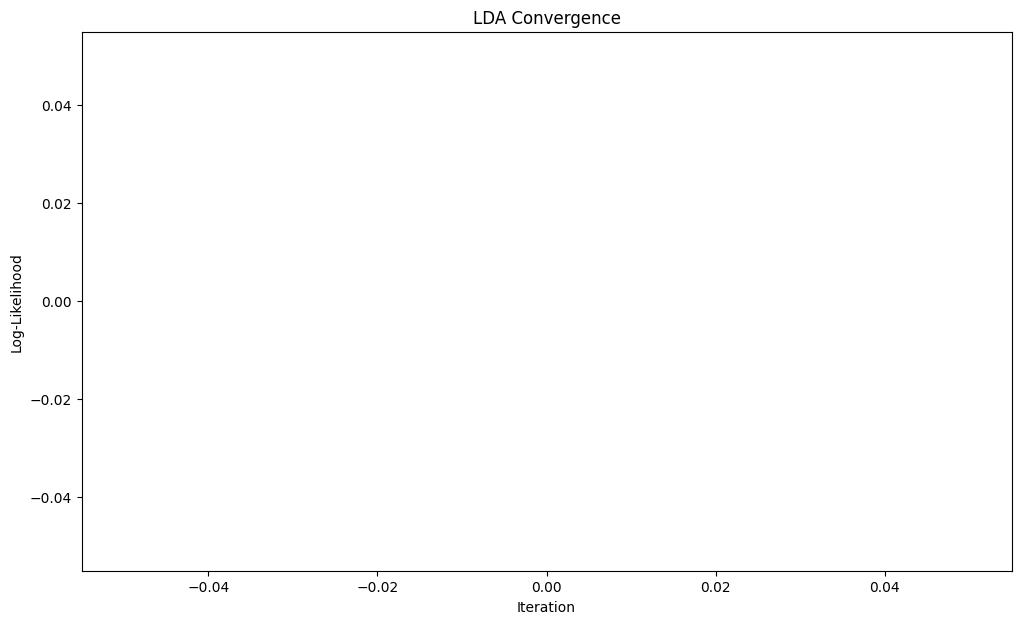

In [34]:
def train_lda_model(ner_corpus=False, tfidf=True):
  if ner_corpus:
    # https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html
    dictionary = corpora.Dictionary.load("ner_dictionary.dict")
    corpus = corpora.MmCorpus("ner_corpus.mm")
  else:
    dictionary = corpora.Dictionary.load("dictionary.dict")
    corpus = corpora.MmCorpus("corpus.mm")

  if tfidf:
    tfidf = models.TfidfModel(corpus)
    corpus = tfidf[corpus]

  # https://radimrehurek.com/gensim/models/ldamodel.html
  # https://stackoverflow.com/questions/37570696/how-to-monitor-convergence-of-gensim-lda-model
  clear_logfile()
  lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=50, eval_every=10)
  likelihoods = parse_logfile()

  # Plot likelihoods for convergence
  fig, ax = plt.subplots(figsize=(12, 7))
  ax.plot(likelihoods)
  ax.set(title="LDA Convergence", xlabel="Iteration", ylabel="Log-Likelihood")

  # Print most important words per topic
  topics = lda.get_topics()
  for topic in range(10):
      topic_probs = topics[topic, :]
      print(f"Topic {topic}: {', '.join([dictionary[i] for i in np.argsort(topic_probs)[-10:]])}")

  return lda

for ner_corpus in [True, False]:
  for tfidf in [True, False]:
    print(f"NER: ", ner_corpus, "\nTF-IDF (BOW if False): ", tfidf)
    lda = train_lda_model(ner_corpus=ner_corpus, tfidf=tfidf)
    print("\n\n")

### BERTopic

In [37]:
# https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html
# https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html

df_blogs = df_blogs.reset_index(drop=True)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(df_blogs.blog)
ner_embeddings = embedding_model.encode(df_blogs.ner_blog)

# Store embeddings to file
with open("embeddings.pkl", "wb") as f:
  pickle.dump(embeddings, f)

with open("ner_embeddings.pkl", "wb") as f:
  pickle.dump(ner_embeddings, f)

In [54]:
# To load saved embeddings if necessary
# with open("embeddings.pkl", "rb") as f:
#   embeddings = pickle.load(f)

# with open("ner_embeddings.pkl", "rb") as f:
#   ner_embeddings = pickle.load(f)

hdbscan_model = HDBSCAN(min_cluster_size=50) # Clustering step
vectorizer_model = CountVectorizer(stop_words=stop_words_to_use) # Tokenizer step
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # c-TF-IDF step
representation_model = KeyBERTInspired() # Fine-tuning step

for ner_corpus in [True, False]:
  print("NER: ", ner_corpus)
  topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)

  if ner_corpus:
    topics, probs = topic_model.fit_transform(df_blogs.blog, ner_embeddings)
    visualization = topic_model.visualize_documents(df_blogs.blog, embeddings=ner_embeddings)
    visualization.write_image("ner_visualization.png")
  else:
    topics, probs = topic_model.fit_transform(df_blogs.blog, embeddings)
    visualization = topic_model.visualize_documents(df_blogs.blog, embeddings=embeddings)
    visualization.write_image("visualization.png")

  print(topic_model.get_topic_info())

NER:  True


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [56]:
visualization.write_image("ner_visualization.png")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
